In [ ]:
# in colab uncomment this

# !wget https://github.com/l3lush/nn_architecture_misis/blob/fall2022/data/archive.zip?raw=true
# !unzip -q /content/archive.zip?raw=true

### Cuda

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda', index=0)

# Transfer learning 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Данные, предобработка

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'  # in colab '/content/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

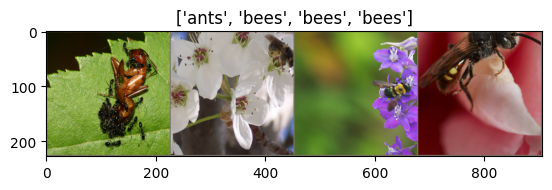

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Рутина обучения

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

## Визуализация работы модели

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Предобученный на ImageNet ResNet-18

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

c:\users\anana\desktop\projs\2022\misis_mag_nn_fall_2022\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\anana\desktop\projs\2022\misis_mag_nn_fall_2022\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Дообучаем все слои

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5528 Acc: 0.7049
val Loss: 0.4289 Acc: 0.8170

Epoch 1/4
----------
train Loss: 0.6326 Acc: 0.7090
val Loss: 0.3906 Acc: 0.8497

Epoch 2/4
----------
train Loss: 0.5496 Acc: 0.7623
val Loss: 0.3166 Acc: 0.8824

Epoch 3/4
----------
train Loss: 0.4393 Acc: 0.8279
val Loss: 0.2614 Acc: 0.9020

Epoch 4/4
----------
train Loss: 0.3148 Acc: 0.8648
val Loss: 0.2347 Acc: 0.9085

Training complete in 0m 60s
Best val Acc: 0.908497


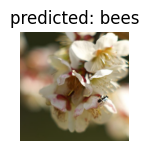

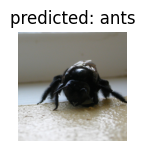

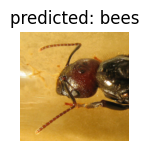

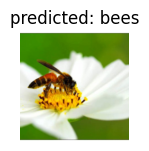

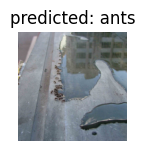

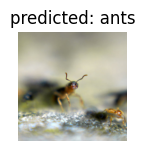

In [10]:
visualize_model(model_ft)

## Теперь дообучаем только последний слой

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    # градиенты теперь не будут здесь протекать
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
# по умолчанию requires_grad = True
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6057 Acc: 0.6721
val Loss: 0.2016 Acc: 0.9412

Epoch 1/4
----------
train Loss: 0.4545 Acc: 0.7910
val Loss: 0.3673 Acc: 0.8105

Epoch 2/4
----------
train Loss: 0.4489 Acc: 0.7664
val Loss: 0.2180 Acc: 0.9281

Epoch 3/4
----------
train Loss: 0.3666 Acc: 0.8484
val Loss: 0.1775 Acc: 0.9412

Epoch 4/4
----------
train Loss: 0.3594 Acc: 0.8443
val Loss: 0.1768 Acc: 0.9477

Training complete in 0m 38s
Best val Acc: 0.947712


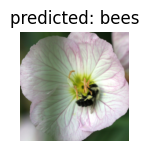

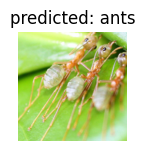

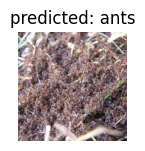

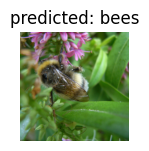

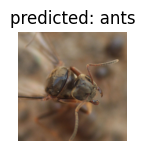

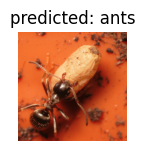

In [13]:
visualize_model(model_conv)

## Предобученный на ImageNet ResNet-152

In [14]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

c:\users\anana\desktop\projs\2022\misis_mag_nn_fall_2022\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.6413 Acc: 0.6885
val Loss: 0.1542 Acc: 0.9477

Epoch 1/2
----------
train Loss: 0.6304 Acc: 0.7459
val Loss: 0.3094 Acc: 0.9085

Epoch 2/2
----------
train Loss: 0.4794 Acc: 0.8238
val Loss: 0.1584 Acc: 0.9673

Training complete in 1m 9s
Best val Acc: 0.967320


# Дообучаем последний слой

In [16]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    # градиенты теперь не будут здесь протекать
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
# по умолчанию requires_grad = True
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.5274 Acc: 0.7131
val Loss: 0.1867 Acc: 0.9412

Epoch 1/2
----------
train Loss: 0.4517 Acc: 0.8115
val Loss: 0.1353 Acc: 0.9477

Epoch 2/2
----------
train Loss: 0.3374 Acc: 0.8607
val Loss: 0.1341 Acc: 0.9673

Training complete in 0m 38s
Best val Acc: 0.967320
